✅ Libraries loaded successfully!
Dataset shape: (1569, 10)

Columns: ['timestamp', 'x', 'y', 'theta', 'linear_speed', 'angular_speed', 'angular_cmd', 'speed_cmd', 'cte', 'safety_flag']

First few rows:
📊 Dataset Statistics:

          timestamp            x            y        theta  linear_speed  \
count  1.569000e+03  1569.000000  1569.000000  1569.000000   1569.000000   
mean   1.767906e+09     4.479077    -0.258649    -0.036549      1.320268   
std    2.332813e+00     2.974367     0.095785     0.187350      0.715040   
min    1.767906e+09     0.000000    -0.393069    -0.422660      0.500000   
25%    1.767906e+09     1.780452    -0.335527    -0.192159      0.500000   
50%    1.767906e+09     4.394855    -0.260060    -0.033817      2.000000   
75%    1.767906e+09     7.153678    -0.227207     0.117025      2.000000   
max    1.767906e+09     9.144220     0.000144     0.315871      2.000000   

       angular_speed  angular_cmd    speed_cmd          cte  safety_flag  
count    1569.0

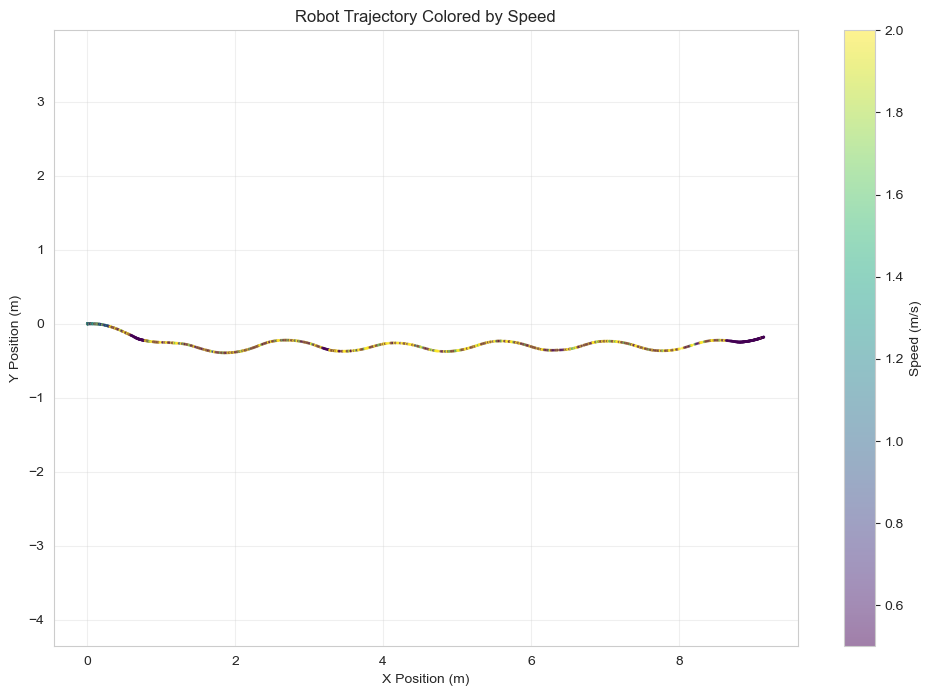

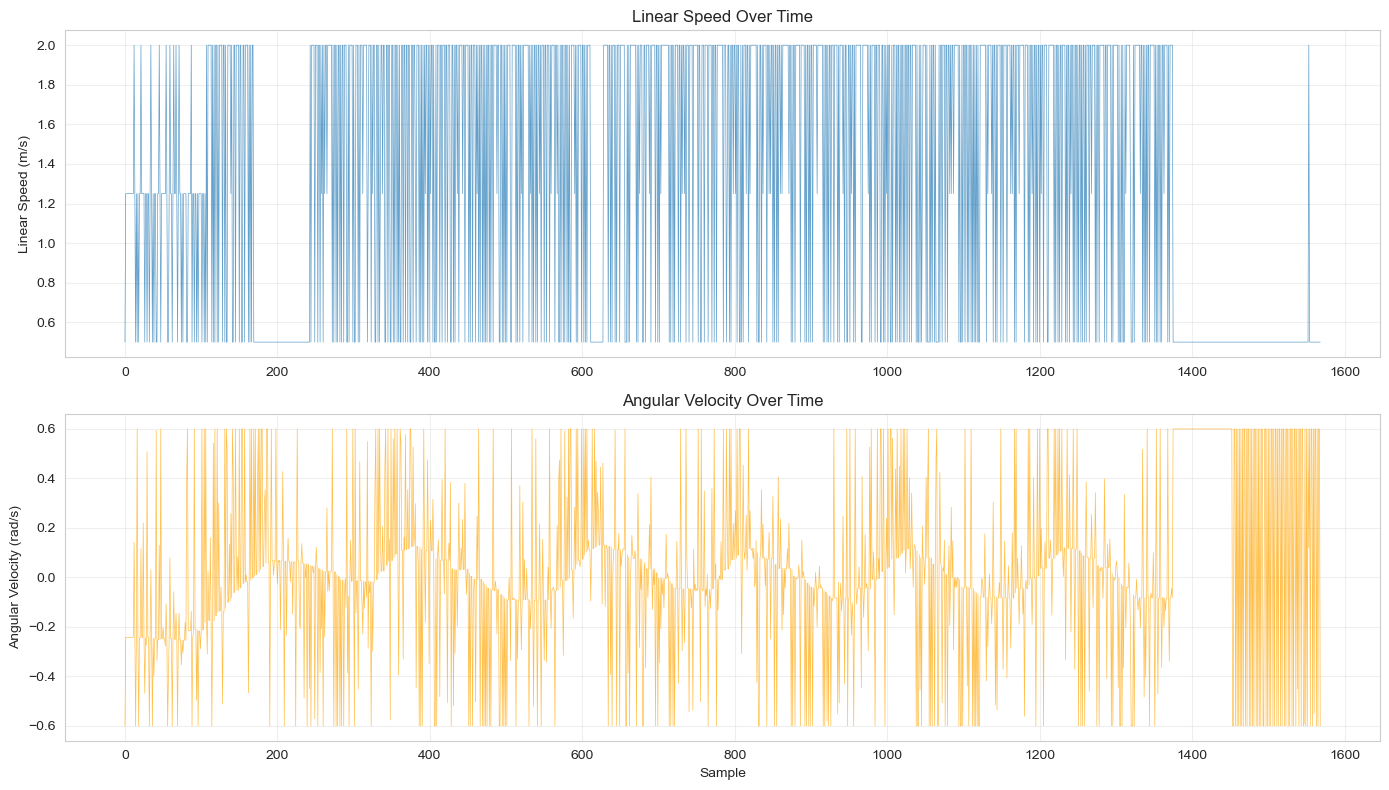

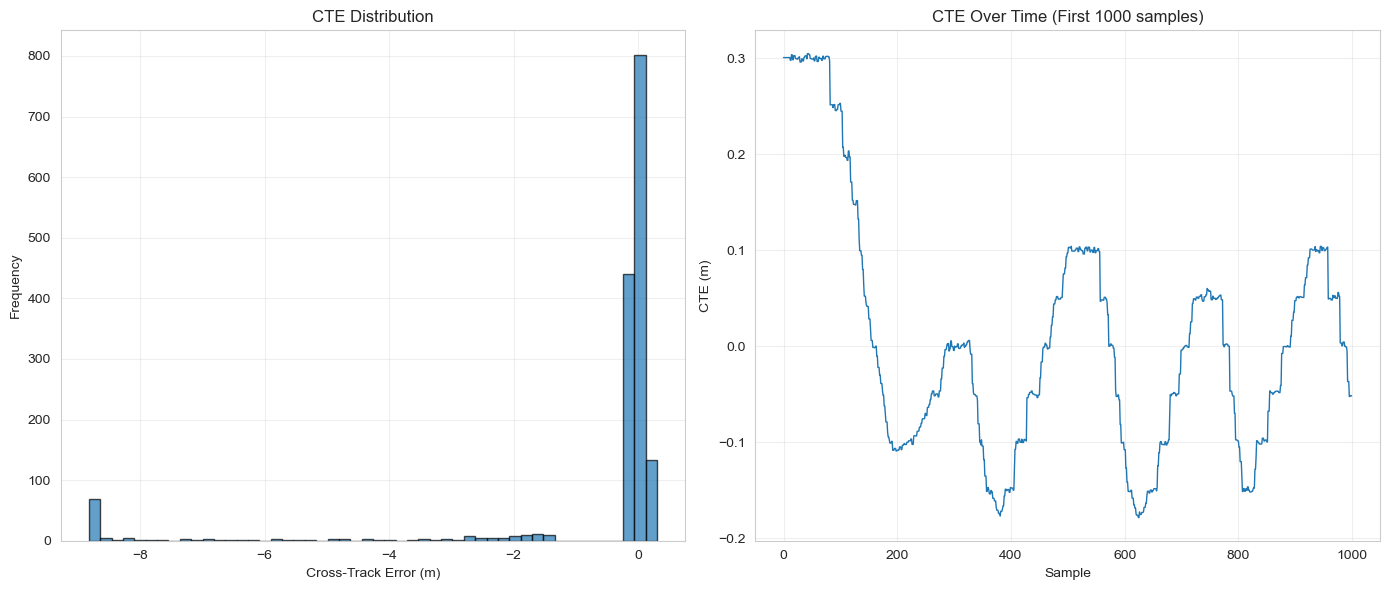

CTE Statistics:
  Mean: -0.7054
  Std: 2.1561
  Min: -8.8233
  Max: 0.3047


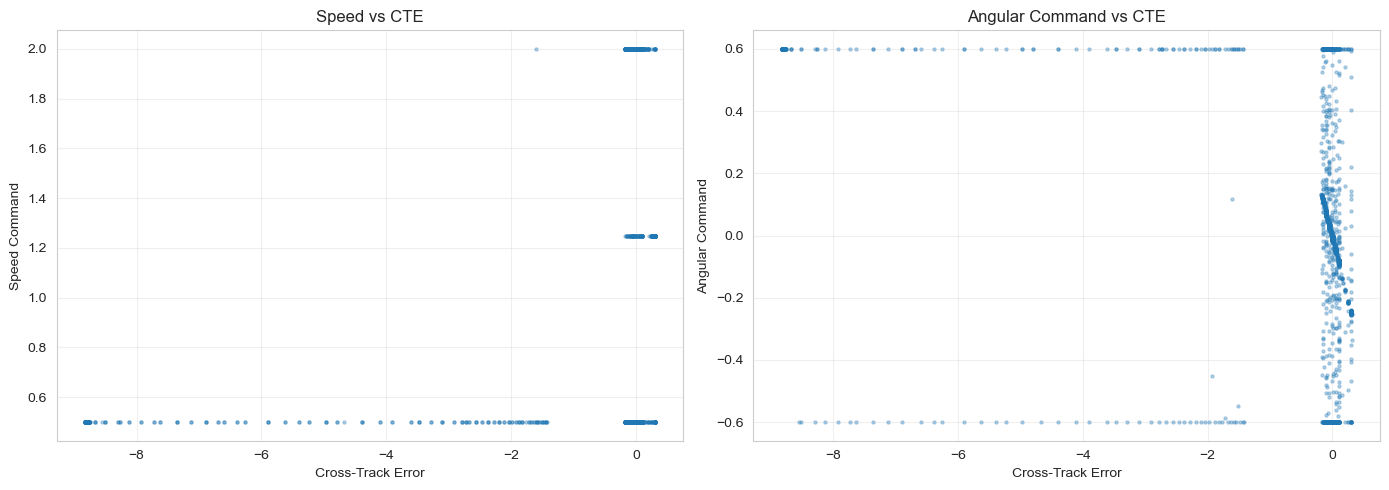

❌ Model not found. Train the model first!


NameError: name 'scaler' is not defined

In [3]:
"""
Interactive Jupyter Notebook for Wall Follower NN
Save as: ~/wall_follower_nn/notebooks/interactive_analysis.ipynb

Run with: jupyter notebook
"""

# Cell 1: Setup
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries loaded successfully!")

# Cell 2: Load Data
#data_path = Path.home() / 'wall_follower_nn' / 'data' / 'pid.csv'
data_path = Path("/Users/shubhamsingh/Documents/lets_Learn/ros2/car_run/wall_follower_nn/data/pid.csv")
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

# Cell 3: Data Overview
print("📊 Dataset Statistics:\n")
print(df.describe())

print(f"\n🚨 Safety Events:")
if 'safety_flag' in df.columns:
    print(df['safety_flag'].value_counts())

# Cell 4: Visualize Trajectory
plt.figure(figsize=(12, 8))
plt.scatter(df['x'], df['y'], c=df['linear_speed'], 
            s=1, cmap='viridis', alpha=0.5)
plt.colorbar(label='Speed (m/s)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Robot Trajectory Colored by Speed')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

# Cell 5: Speed and Angular Velocity Over Time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df['linear_speed'], linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Linear Speed (m/s)')
axes[0].set_title('Linear Speed Over Time')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['angular_speed'], linewidth=0.5, alpha=0.7, color='orange')
axes[1].set_ylabel('Angular Velocity (rad/s)')
axes[1].set_xlabel('Sample')
axes[1].set_title('Angular Velocity Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Cross-Track Error Analysis
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['cte'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Cross-Track Error (m)')
plt.ylabel('Frequency')
plt.title('CTE Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(df['cte'][:1000], linewidth=1)
plt.xlabel('Sample')
plt.ylabel('CTE (m)')
plt.title('CTE Over Time (First 1000 samples)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"CTE Statistics:")
print(f"  Mean: {df['cte'].mean():.4f}")
print(f"  Std: {df['cte'].std():.4f}")
print(f"  Min: {df['cte'].min():.4f}")
print(f"  Max: {df['cte'].max():.4f}")

# Cell 7: Control Commands Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['cte'], df['speed_cmd'], alpha=0.3, s=5)
axes[0].set_xlabel('Cross-Track Error')
axes[0].set_ylabel('Speed Command')
axes[0].set_title('Speed vs CTE')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df['cte'], df['angular_cmd'], alpha=0.3, s=5)
axes[1].set_xlabel('Cross-Track Error')
axes[1].set_ylabel('Angular Command')
axes[1].set_title('Angular Command vs CTE')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 8: Load Trained Model
model_path = Path.home() / 'wall_follower_nn' / 'models' / 'wall_follower_model.pth'
scaler_path = Path.home() / 'wall_follower_nn' / 'models' / 'scaler.pkl'

if model_path.exists() and scaler_path.exists():
    print("✅ Model and scaler found!")
    
    # Load scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    # Define model architecture (must match training)
    class WallFollowerNet(torch.nn.Module):
        def __init__(self, input_size=4, hidden_sizes=[128, 64, 32], output_size=2):
            super(WallFollowerNet, self).__init__()
            layers = []
            prev_size = input_size
            for hidden_size in hidden_sizes:
                layers.append(torch.nn.Linear(prev_size, hidden_size))
                layers.append(torch.nn.ReLU())
                layers.append(torch.nn.Dropout(0.2))
                prev_size = hidden_size
            layers.append(torch.nn.Linear(prev_size, output_size))
            self.network = torch.nn.Sequential(*layers)
        
        def forward(self, x):
            return self.network(x)
    
    # Load model
    model = WallFollowerNet()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()
    
    print("✅ Model loaded successfully!")
else:
    print("❌ Model not found. Train the model first!")

# Cell 9: Test Model Predictions
# Clean data (remove safety events)
df_clean = df[df['safety_flag'] == 0].copy()

# Prepare features
features = df_clean[['cte', 'theta', 'linear_speed', 'angular_speed']].values[:1000]
labels = df_clean[['speed_cmd', 'angular_cmd']].values[:1000]

# Scale and predict
features_scaled = scaler.transform(features)
features_tensor = torch.FloatTensor(features_scaled)

with torch.no_grad():
    predictions = model(features_tensor).numpy()

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(labels[:, 0], label='Actual Speed', alpha=0.7, linewidth=1.5)
axes[0].plot(predictions[:, 0], label='Predicted Speed', alpha=0.7, linewidth=1.5)
axes[0].set_ylabel('Speed Command (m/s)')
axes[0].set_title('Model Predictions vs Actual - Speed')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(labels[:, 1], label='Actual Angular', alpha=0.7, linewidth=1.5)
axes[1].plot(predictions[:, 1], label='Predicted Angular', alpha=0.7, linewidth=1.5)
axes[1].set_ylabel('Angular Command (rad/s)')
axes[1].set_xlabel('Sample')
axes[1].set_title('Model Predictions vs Actual - Angular')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate errors
speed_error = np.abs(predictions[:, 0] - labels[:, 0])
angular_error = np.abs(predictions[:, 1] - labels[:, 1])

print(f"\n📊 Prediction Errors:")
print(f"Speed MAE: {speed_error.mean():.6f} m/s")
print(f"Angular MAE: {angular_error.mean():.6f} rad/s")

# Cell 10: Interactive Prediction
def predict_control(cte, theta=0.0, linear_speed=1.5, angular_speed=0.0):
    """Interactive prediction function"""
    features = np.array([[cte, theta, linear_speed, angular_speed]])
    features_scaled = scaler.transform(features)
    features_tensor = torch.FloatTensor(features_scaled)
    
    with torch.no_grad():
        prediction = model(features_tensor).numpy()[0]
    
    print(f"Input:")
    print(f"  CTE: {cte:.3f} m")
    print(f"  Theta: {theta:.3f} rad")
    print(f"  Linear Speed: {linear_speed:.3f} m/s")
    print(f"  Angular Speed: {angular_speed:.3f} rad/s")
    print(f"\nPredicted Control:")
    print(f"  Speed Command: {prediction[0]:.3f} m/s")
    print(f"  Angular Command: {prediction[1]:.3f} rad/s")
    
    return prediction

# Test with different CTE values
print("🧪 Testing different scenarios:\n")
print("Scenario 1: Small positive CTE")
predict_control(cte=0.1)

print("\n" + "="*50)
print("\nScenario 2: Large positive CTE")
predict_control(cte=0.5)

print("\n" + "="*50)
print("\nScenario 3: Negative CTE")
predict_control(cte=-0.3)